In [1]:
!pip install imbalanced-learn

    100% |████████████████████████████████| 163kB 7.1MB/s ta 0:00:01
    100% |████████████████████████████████| 7.3MB 6.2MB/s eta 0:00:01
    100% |████████████████████████████████| 296kB 46.9MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import GridSearchCV

# USE sagemaker.xgboost when using AWS

#from xgboost import XGBClassifier
#from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

---
## User-Defined Functions

In [5]:
# Purposedfully omitted
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

---
## Data Preprocessing and EDA

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


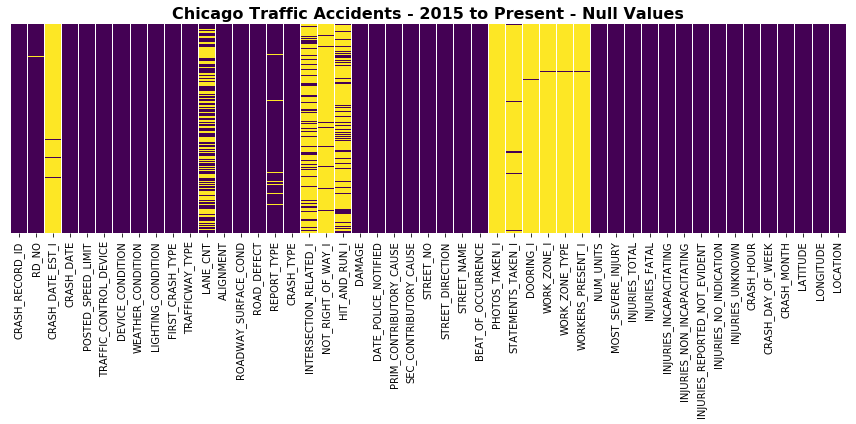

In [6]:
accidents = pd.read_csv('data/traffic_crashes.csv')
plt.figure(figsize=(12,6))
sns.heatmap(accidents.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Chicago Traffic Accidents - 2015 to Present - Null Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('chi_accidents_null.png');

In [7]:
# Develop classification flag.
# Positive represents the accideent resulted in incapacitation and/or fatality.
accidents['crash_date'] = pd.to_datetime(accidents['CRASH_DATE'])
accidents['crash_year'] = accidents['crash_date'].dt.year
accidents['fatal_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'FATAL', 1, 0)
accidents['incap_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY', 1, 0)
accidents['fatal_incap'] = accidents['fatal_bool'] + accidents['incap_bool']
accidents.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,crash_date,crash_year,fatal_bool,incap_bool,fatal_incap
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,JC201794,NaN,03/27/2019 04:20:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,...,4,3,41.994704,-87.699395,POINT (-87.699395085278 41.994703544264),2019-03-27 16:20:00,2019,0,0,0
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,JB175900,NaN,03/06/2018 03:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,3,3,41.904671,-87.716685,POINT (-87.716685434641 41.904671135876),2018-03-06 15:00:00,2018,0,0,0
2,0003fc68d857da032b1beafa8f7893ce0b123ce6b2dee5...,HZ488533,NaN,10/25/2016 02:10:00 PM,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,DAYLIGHT,REAR END,...,3,10,41.706808,-87.642771,POINT (-87.642771373276 41.706807861572),2016-10-25 14:10:00,2016,0,0,0
3,00060f93d2ae8d4e4c7fe75ac17055dd69a081d0b928a5...,JD123586,NaN,01/21/2020 04:16:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,...,3,1,41.791610,-87.703356,POINT (-87.703355598231 41.791609871969),2020-01-21 16:16:00,2020,0,0,0
4,0006882952e53c291df267014a03b57684383e9ad66d9e...,JC459747,NaN,10/04/2019 12:00:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,6,10,41.848490,-87.675599,POINT (-87.67559940405 41.848490427751),2019-10-04 12:00:00,2019,0,0,0


In [6]:
# 

In [7]:
# Started collecting data for the entire city in September 2017.
# Data collection became more formalized.
# Omitting data prior to March 2020 due to Covid-19 pandemic.
accidents = accidents[(accidents['crash_date'] > '2017-08-31') & (accidents['crash_date'] < '2020-03-01')]
len(accidents)

292080

In [8]:
num_pos_obs = sum(accidents['fatal_incap'])
num_neg_obs = len(accidents['fatal_incap']) - num_pos_obs
print("# of POSITIVE Obs.: ", num_pos_obs)
print("# of NEGATIVE Obs.: ", num_neg_obs)
print("% of Positive Obs. (Fatalities): ", round(sum(accidents['fatal_incap']) / len(accidents['fatal_incap']), 4))

# of POSITIVE Obs.:  5358
# of NEGATIVE Obs.:  286722
% of Positive Obs. (Fatalities):  0.0183


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Returns TRUE if Total # of Accidents Reconcile:  True


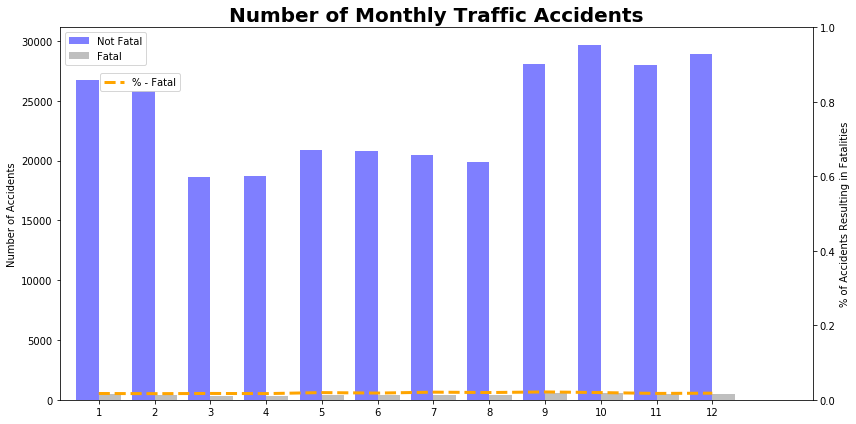

In [9]:
# Create data frame
month_grpd = accidents.groupby(['CRASH_MONTH', 'fatal_incap']).agg({'fatal_incap':'count'})
month_grpd.columns = ['count']
month_grpd.reset_index(inplace=True)
month_no_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 0]
month_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 1]

month_fatal_df = pd.DataFrame()
month_fatal_df['month'] = pd.Series(range(1,13))
month_fatal_df['num_not_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 0]['count'])
month_fatal_df['num_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 1]['count'])
month_fatal_df['total'] = month_fatal_df['num_not_fatal'] + month_fatal_df['num_fatal']
month_fatal_df['prcnt_fatal'] = month_fatal_df['num_fatal'] / month_fatal_df['total']

pos = list(range(len(month_fatal_df['month'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, month_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos], month_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(month_fatal_df['month'])
ax1.set_title('Number of Monthly Traffic Accidents', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, 13)

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos], month_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(month_fatal_df['total'])==len(accidents)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Returns TRUE if Total # of Accidents Reconcile:  True


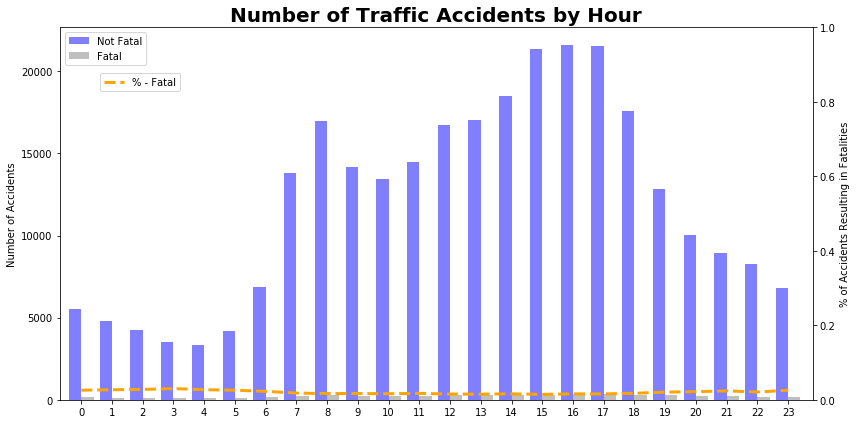

In [10]:
# ACCIDENTS BY HOUR
hour_grpd = accidents.groupby(['CRASH_HOUR', 'fatal_incap']).agg({'fatal_incap':'count'})
hour_grpd.columns = ['count']
hour_grpd.reset_index(inplace=True)
hour_no_fatal = hour_grpd[hour_grpd['fatal_incap'] == 0]
hour_fatal_ = hour_grpd[hour_grpd['fatal_incap'] == 1]

hour_fatal_df = pd.DataFrame()
hour_fatal_df['hour'] = pd.Series(range(0,24))
hour_fatal_df['num_not_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 0]['count'])
hour_fatal_df['num_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 1]['count'])
hour_fatal_df['total'] = hour_fatal_df['num_not_fatal'] + hour_fatal_df['num_fatal']
hour_fatal_df['prcnt_fatal'] = hour_fatal_df['num_fatal'] / hour_fatal_df['total']

pos_hour = list(range(len(hour_fatal_df['hour'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos_hour, hour_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos_hour], hour_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos_hour])
ax1.set_xticklabels(hour_fatal_df['hour'])
ax1.set_title('Number of Traffic Accidents by Hour', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, len(hour_fatal_df))

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos_hour], hour_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(hour_fatal_df['total'])==len(accidents)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


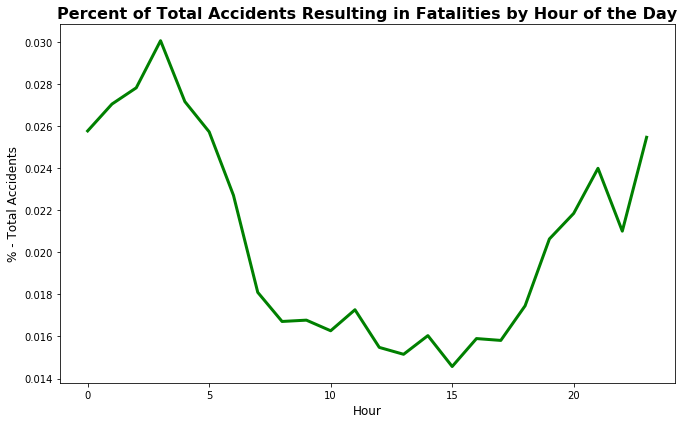

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pos_hour, hour_fatal_df['prcnt_fatal'] , color='green',  linewidth=3)
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Hour of the Day', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
fig.tight_layout()

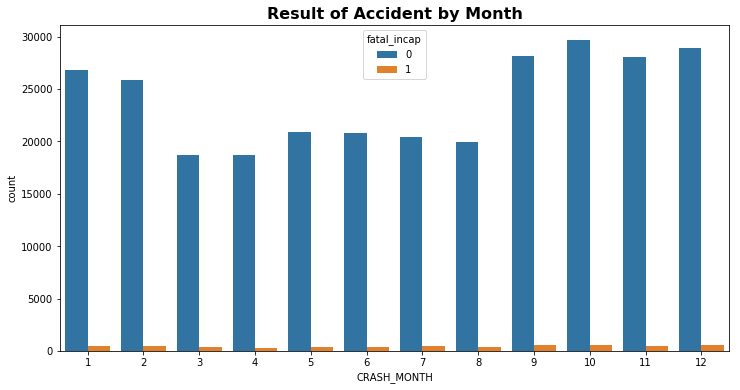

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='CRASH_MONTH', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Month", fontsize=16, fontweight='bold');

In [13]:
# ACCIDENTS BY DAY OF THE WEEK

accidents_spd_lim = accidents[accidents['POSTED_SPEED_LIMIT'] % 5 == 0].copy()
spd_lim_pivot = accidents_spd_lim.pivot_table(index='POSTED_SPEED_LIMIT', columns='fatal_incap', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
#spd_lim_pivot.drop('fatal_incap', axis=1, inplace=True)
spd_lim_pivot.rename({0:'num_not_fatal', 1:'num_fatal'}, axis=1, inplace=True)
spd_lim_pivot['total'] = spd_lim_pivot['num_not_fatal'] + spd_lim_pivot['num_fatal']
spd_lim_pivot['prcnt_fatal'] = spd_lim_pivot['num_fatal'] / spd_lim_pivot['total']

fig, ax = plt.subplots(figsize=(12,6))
spd_arr = spd_lim_pivot['POSTED_SPEED_LIMIT'].values
spd_prcnt_fatal_arr = spd_lim_pivot['prcnt_fatal'].values
spd_total_arr_nrml = spd_lim_pivot['total'].values / sum(spd_lim_pivot['total'])

ax.plot(spd_arr, spd_prcnt_fatal_arr , color='green',  linewidth=3, label='% - Total')
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Posted Speed Limit', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
ax.legend()

# Share x-axis
ax2=ax.twinx()

#ax2.set_ylim(0, 100000)
ax2.set_ylabel('# - Total Accidents Normalized')
ax2.plot(spd_arr, spd_total_arr_nrml , color='purple', linestyle='--', linewidth=3, 
         label='# - Total Accidents Normalized')

ax2.legend(loc='upper left', facecolor='white')
ax2.grid(color=None, linestyle='None')

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

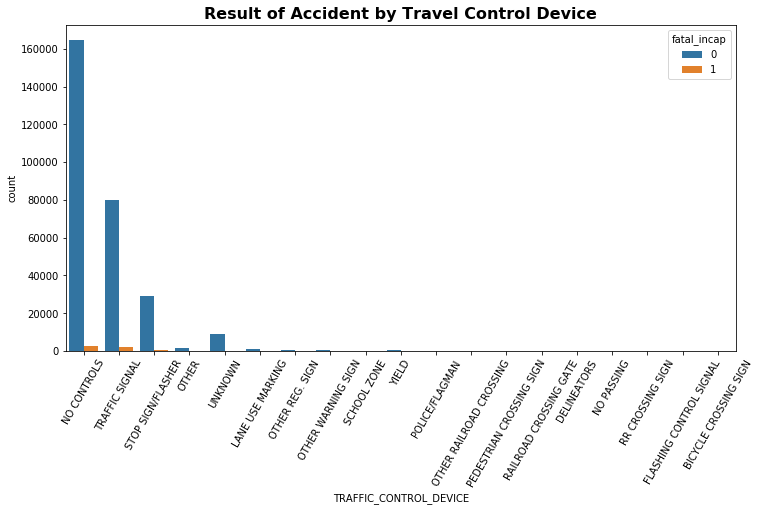

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x='TRAFFIC_CONTROL_DEVICE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

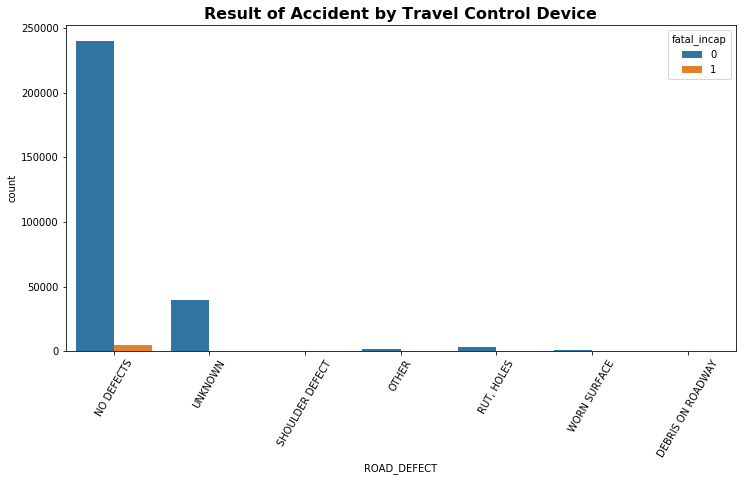

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x='ROAD_DEFECT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

In [16]:
accidents_speed_limt = accidents[accidents['POSTEDS_SPEED_']]
plt.figure(figsize=(12,6))
sns.countplot(x='POSTED_SPEED_LIMIT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

KeyError: 'POSTEDS_SPEED_'

fatal_incap,CRASH_DAY_OF_WEEK,num_not_fatal,num_fatal,total,prcnt_fatal
0,1,47188,868,48056,0.018062
1,2,55420,897,56317,0.015928
2,3,57673,906,58579,0.015466
3,4,56933,902,57835,0.015596
4,5,57425,917,58342,0.015718
5,6,64655,989,65644,0.015066
6,7,57982,1017,58999,0.017238


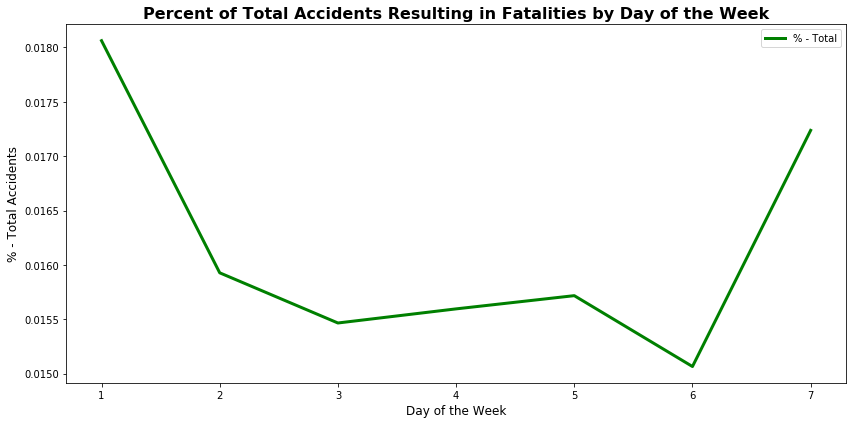

In [28]:
# TRAFFIC ACCIDENTS BY DAY OF THE WEEK

day_pivot = accidents.pivot_table(index='CRASH_DAY_OF_WEEK', columns='fatal_incap', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
#spd_lim_pivot.drop('fatal_incap', axis=1, inplace=True)
day_pivot.rename({0:'num_not_fatal', 1:'num_fatal'}, axis=1, inplace=True)
day_pivot['total'] = day_pivot['num_not_fatal'] + day_pivot['num_fatal']
day_pivot['prcnt_fatal'] = day_pivot['num_fatal'] / day_pivot['total']

fig, ax = plt.subplots(figsize=(12,6))
day_arr = day_pivot['CRASH_DAY_OF_WEEK'].values
day_prcnt_fatal_arr = day_pivot['prcnt_fatal'].values
#day_total_arr_nrml = spd_lim_pivot['total'].values / sum(spd_lim_pivot['total'])

ax.plot(day_arr, day_prcnt_fatal_arr , color='green',  linewidth=3, label='% - Total')
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Day of the Week', fontsize=16, fontweight='bold')
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
ax.legend()

"""
# Share x-axis
ax2=ax.twinx()

#ax2.set_ylim(0, 100000)
ax2.set_ylabel('# - Total Accidents Normalized')
ax2.plot(spd_arr, spd_total_arr_nrml , color='purple', linestyle='--', linewidth=3, 
         label='# - Total Accidents Normalized')

ax2.legend(loc='upper left', facecolor='white')
ax2.grid(color=None, linestyle='None')
"""
fig.tight_layout()
day_pivot

In [17]:
spd_lim_pivot

NameError: name 'spd_lim_pivot' is not defined

In [ ]:
spd_lim_grpd
#print(range(0,len(spd_lim_grpd)))
#len(spd_lim_grpd[spd_lim_grpd['fatal_incap'] == 0])

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='PRIM_CONTRIBUTORY_CAUSE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

In [ ]:
accidents.columns

---
# CREATE THE FINAL DATASET

In [42]:
# Excluded "after-the-fact" features, e.g. DAMAGE($), DOORING_I
# Omitted geospatial data, SEC_CONTRIBUTORY_CAUSE, LANE_CNT.
# Construction information does not provide significant value.
# Removed CRASH_TYPE because its values are the results of the accidents.
accidents2 = accidents[['CRASH_RECORD_ID', 'RD_NO', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                        'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
                        'ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT', 
                        'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 
                        'PRIM_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 
                        'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
                        'crash_date', 'crash_year','fatal_incap']].copy()

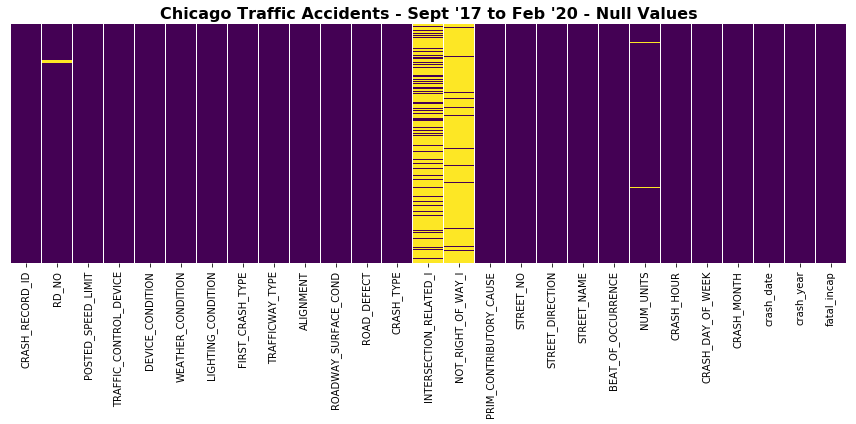

In [9]:
plt.figure(figsize=(12,6))
sns.heatmap(accidents2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Chicago Traffic Accidents - Sept '17 to Feb '20 - Null Values", fontsize=16, fontweight='bold')
plt.savefig('chi_accidents_null.png');
plt.tight_layout();

In [10]:
accidents['NUM_UNITS'].unique()

array([ 2.,  3.,  1., nan,  4.,  8.,  5.,  6.,  7., 10., 11.,  9., 18.,
       15., 12., 16.])

---
## Create X Subsets for Model Train/Test

#### Variables are imbalanced.

# Y

In [11]:
y_all_true = accidents2[['fatal_incap']]

---
## X1

In [12]:
# X1
# Rmoving POSTED_SPEED_LIMIT and CRASH_HOUR b/c importance is inflated.
X_1 = accidents[['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION']]
trfc_cntrl = pd.get_dummies(X_1['TRAFFIC_CONTROL_DEVICE'])
wthr_cndtn = pd.get_dummies(X_1['WEATHER_CONDITION'])
lghtng_cndtn = pd.get_dummies(X_1['LIGHTING_CONDITION'])
X_1 = pd.concat([X_1, trfc_cntrl, wthr_cndtn, lghtng_cndtn], axis=1)
X_1.drop(['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION'], axis=1, inplace=True)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1.values, y_all_true.values,test_size=0.20, random_state=42)

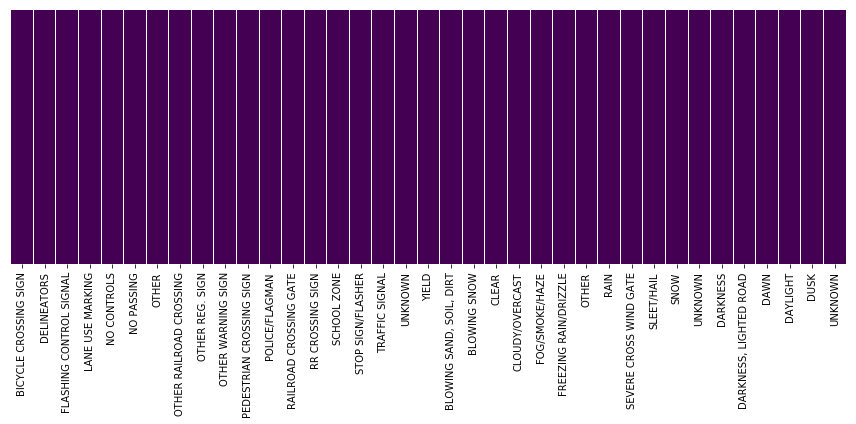

In [13]:
plt.figure(figsize=(12,6))
sns.heatmap(X_1.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout();

---
## X2

In [14]:
X_2 = accidents2[['PRIM_CONTRIBUTORY_CAUSE','ROADWAY_SURFACE_COND','ROAD_DEFECT']]
prime_cause = pd.get_dummies(accidents2['PRIM_CONTRIBUTORY_CAUSE'])
road_surface = pd.get_dummies(accidents2['ROADWAY_SURFACE_COND'])
road_defect = pd.get_dummies(accidents2['ROAD_DEFECT'])
X_2 = pd.concat([prime_cause, road_surface, road_defect], axis=1)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2.values, y_all_true.values,test_size=0.20, random_state=42)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


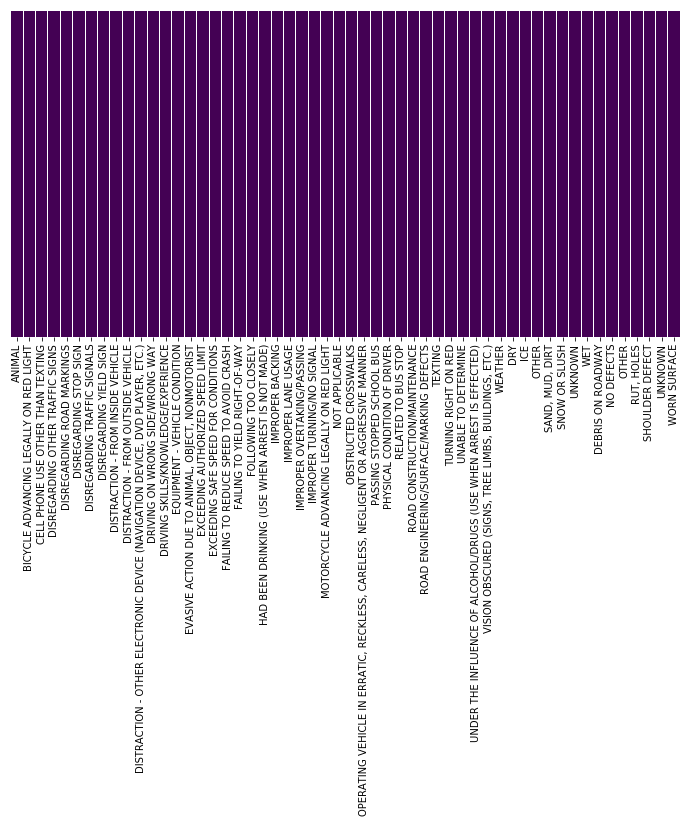

In [15]:
plt.figure(figsize=(12,6))
sns.heatmap(X_2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout();

---
## X3

In [16]:
X_3 = accidents[['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION', 
                 'PRIM_CONTRIBUTORY_CAUSE']]
trfc_cntrl_x3 = pd.get_dummies(X_3['TRAFFIC_CONTROL_DEVICE'])
prime_cause_x3= pd.get_dummies(X_3['PRIM_CONTRIBUTORY_CAUSE'])
lghtng_cndtn_x3 = pd.get_dummies(X_3['LIGHTING_CONDITION'])

no_trfc_cntrl_x3= trfc_cntrl_x3[['NO CONTROLS']]
drkns_lghtng_rd_x3 = lghtng_cndtn_x3['DARKNESS, LIGHTED ROAD']
prime_cause_sub_x3 = prime_cause_x3[['DISREGARDING TRAFFIC SIGNALS','FOLLOWING TOO CLOSELY', 'IMPROPER BACKING',
                                     'FAILING TO YIELD RIGHT-OF-WAY']]
x3_concat_lst = [X_3[['POSTED_SPEED_LIMIT', 'CRASH_HOUR']], no_trfc_cntrl_x3, drkns_lghtng_rd_x3, prime_cause_sub_x3]
X_3 = pd.concat(x3_concat_lst, axis=1)

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3.values, y_all_true.values, test_size=0.20, random_state=42)

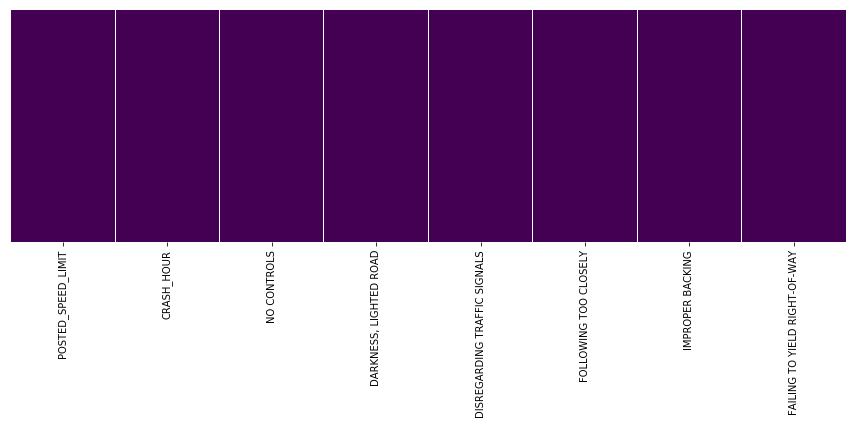

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(X_3.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout();

---
## X4

In [48]:
accidents['FIRST_CRASH_TYPE'].unique()

array(['ANGLE', 'SIDESWIPE SAME DIRECTION', 'REAR END', 'PEDESTRIAN',
       'PARKED MOTOR VEHICLE', 'TURNING', 'HEAD ON', 'PEDALCYCLIST',
       'SIDESWIPE OPPOSITE DIRECTION', 'OTHER NONCOLLISION',
       'FIXED OBJECT', 'OTHER OBJECT', 'REAR TO FRONT', 'REAR TO SIDE',
       'REAR TO REAR', 'TRAIN', 'OVERTURNED', 'ANIMAL'], dtype=object)

In [43]:
X_4 = accidents2[['DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
                  'ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT']]

device_x4 = pd.get_dummies(X_4['DEVICE_CONDITION'])
weather_x4 = pd.get_dummies(X_4['WEATHER_CONDITION'])
lighting_x4 = pd.get_dummies(X_4['LIGHTING_CONDITION'])
first_crash_x4 = pd.get_dummies(X_4['FIRST_CRASH_TYPE'])
trafficway_x4 = pd.get_dummies(X_4['TRAFFICWAY_TYPE'])
alignment_x4 = pd.get_dummies(X_4['ALIGNMENT'])
roadway_surface_x4 = pd.get_dummies(X_4['ROADWAY_SURFACE_COND'])
road_defect_x4 = pd.get_dummies(X_4['ROAD_DEFECT'])

x4_concat_lst = [device_x4, weather_x4, lighting_x4, first_crash_x4, trafficway_x4, alignment_x4, roadway_surface_x4,
                road_defect_x4]
X_4 = pd.concat(x4_concat_lst, axis=1)

X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4.values, y_all_true.values, test_size=0.20, random_state=42)

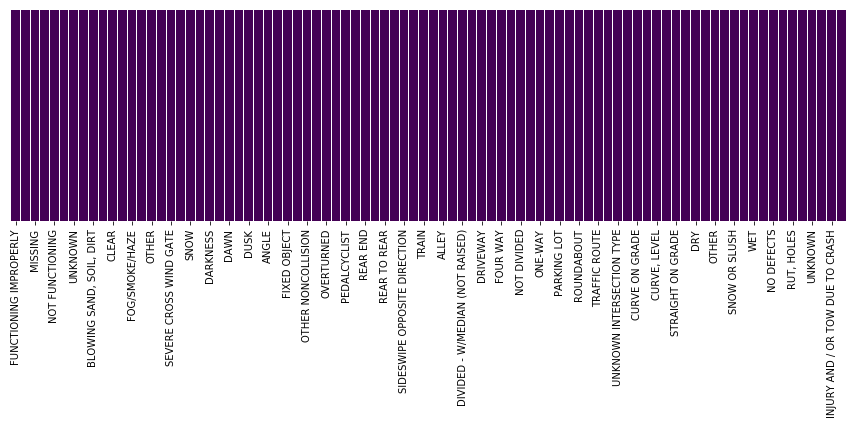

In [31]:
plt.figure(figsize=(12,6))
sns.heatmap(X_4.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout();

---
### XGBoost (Built-in Hyperparameter) - Oversampling - X1

In [28]:
# No oversampling
xgboost = XGBClassifier(random_state=1, learning_rate=0.1)
xgboost.fit(X_1_train, y_1_train.ravel())
y_pred_xgb = xgboost.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_pred_xgb))
print(classification_report(y_1_test.ravel(), y_pred_xgb))

NameError: name 'XGBClassifier' is not defined

In [ ]:
xgboost_scld = XGBClassifier(random_state=1, learning_rate=0.1, scale_pos_weight=num_neg_obs/num_pos_obs )
xgboost_scld.fit(X_1_train, y_1_train.ravel())
y_pred_xgb_scld = xgboost_scld.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_pred_xgb_scld))
print(classification_report(y_1_test.ravel(), y_pred_xgb_scld))

In [539]:
for i, col in enumerate(X_1.columns):
    print("f{} = {}".format(i, col))

f0 = BICYCLE CROSSING SIGN
f1 = DELINEATORS
f2 = FLASHING CONTROL SIGNAL
f3 = LANE USE MARKING
f4 = NO CONTROLS
f5 = NO PASSING
f6 = OTHER
f7 = OTHER RAILROAD CROSSING
f8 = OTHER REG. SIGN
f9 = OTHER WARNING SIGN
f10 = PEDESTRIAN CROSSING SIGN
f11 = POLICE/FLAGMAN
f12 = RAILROAD CROSSING GATE
f13 = RR CROSSING SIGN
f14 = SCHOOL ZONE
f15 = STOP SIGN/FLASHER
f16 = TRAFFIC SIGNAL
f17 = UNKNOWN
f18 = YIELD
f19 = BLOWING SAND, SOIL, DIRT
f20 = BLOWING SNOW
f21 = CLEAR
f22 = CLOUDY/OVERCAST
f23 = FOG/SMOKE/HAZE
f24 = FREEZING RAIN/DRIZZLE
f25 = OTHER
f26 = RAIN
f27 = SEVERE CROSS WIND GATE
f28 = SLEET/HAIL
f29 = SNOW
f30 = UNKNOWN
f31 = DARKNESS
f32 = DARKNESS, LIGHTED ROAD
f33 = DAWN
f34 = DAYLIGHT
f35 = DUSK
f36 = UNKNOWN


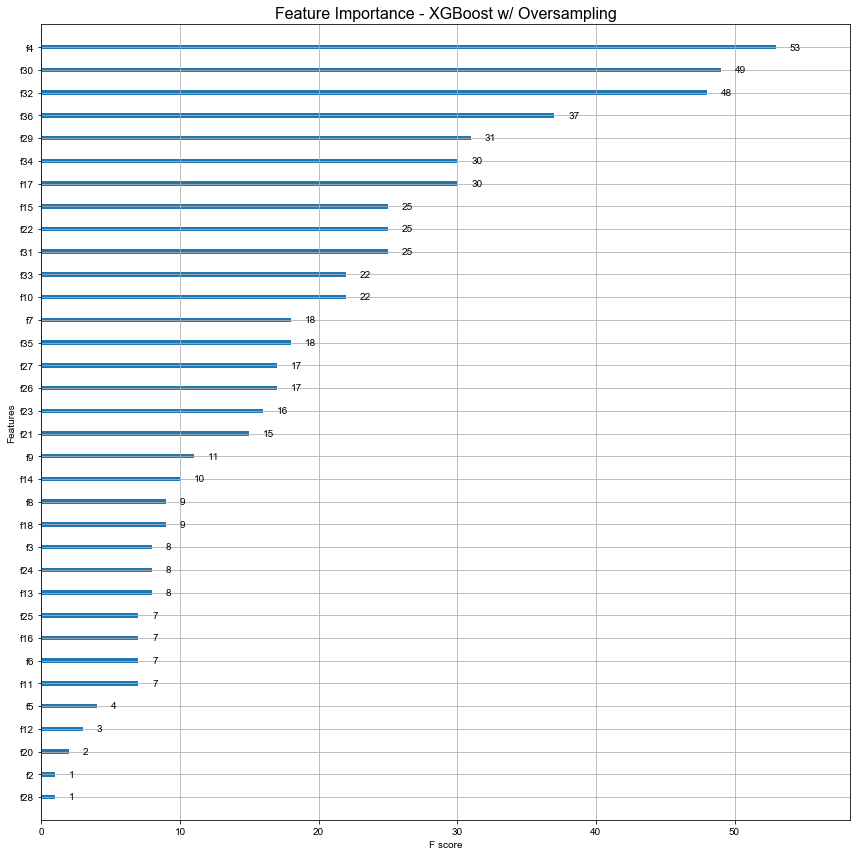

In [540]:
#plt.figure(figsize=(12,6))
#plot_importance(xgboost_scld)

plt.rcParams['figure.figsize'] = (12,12)
plot_importance(xgboost_scld)#.set_yticklabels(reversed(X_1_dum.columns))
plt.title("Feature Importance - XGBoost w/ Oversampling", fontsize=16)
plt.tight_layout();

---
### XGBoost (Built-in Hyperparameter) - Oversampling - X2 

#### Primary Cause, Roadway Condition and Road Defect

In [541]:
xgboost_scld_2 = XGBClassifier(random_state=1, learning_rate=0.1, scale_pos_weight=num_neg_obs/num_pos_obs )
xgboost_scld_2.fit(X_2_train, y_2_train.ravel())
y_2_pred_xgb_scld = xgboost_scld_2.predict(X_2_test)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_xgb_scld))
print(classification_report(y_2_test.ravel(), y_2_pred_xgb_scld))

[[59838 19589]
 [  593   735]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     79427
           1       0.04      0.55      0.07      1328

    accuracy                           0.75     80755
   macro avg       0.51      0.65      0.46     80755
weighted avg       0.97      0.75      0.84     80755



In [542]:
for i, col in enumerate(X_2.columns):
    print("f{} = {}".format(i, col))

f0 = ANIMAL
f1 = BICYCLE ADVANCING LEGALLY ON RED LIGHT
f2 = CELL PHONE USE OTHER THAN TEXTING
f3 = DISREGARDING OTHER TRAFFIC SIGNS
f4 = DISREGARDING ROAD MARKINGS
f5 = DISREGARDING STOP SIGN
f6 = DISREGARDING TRAFFIC SIGNALS
f7 = DISREGARDING YIELD SIGN
f8 = DISTRACTION - FROM INSIDE VEHICLE
f9 = DISTRACTION - FROM OUTSIDE VEHICLE
f10 = DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)
f11 = DRIVING ON WRONG SIDE/WRONG WAY
f12 = DRIVING SKILLS/KNOWLEDGE/EXPERIENCE
f13 = EQUIPMENT - VEHICLE CONDITION
f14 = EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST
f15 = EXCEEDING AUTHORIZED SPEED LIMIT
f16 = EXCEEDING SAFE SPEED FOR CONDITIONS
f17 = FAILING TO REDUCE SPEED TO AVOID CRASH
f18 = FAILING TO YIELD RIGHT-OF-WAY
f19 = FOLLOWING TOO CLOSELY
f20 = HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)
f21 = IMPROPER BACKING
f22 = IMPROPER LANE USAGE
f23 = IMPROPER OVERTAKING/PASSING
f24 = IMPROPER TURNING/NO SIGNAL
f25 = MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT
f26

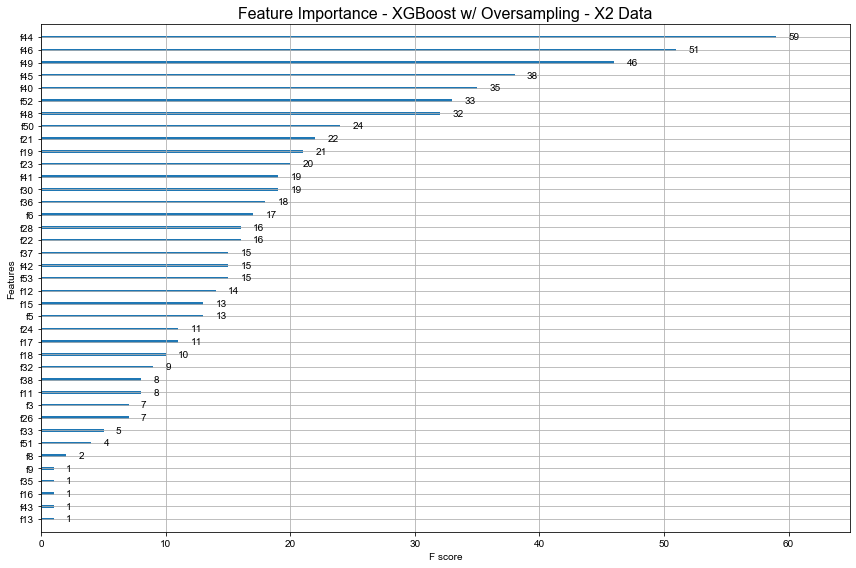

In [543]:
plt.rcParams['figure.figsize'] = (12,8)
plot_importance(xgboost_scld_2)#.set_yticklabels(X_2_dum.columns)
plt.title("Feature Importance - XGBoost w/ Oversampling - X2 Data", fontsize=16)
plt.tight_layout();

---
### SMOTE / Gradient Boost - X1 Dataset

In [544]:
oversampler = SMOTE(random_state=0, k_neighbors=5)
X_1_train_os, y_1_train_os = oversampler.fit_sample(X_1_train, y_1_train.ravel())

#print(y_1_train.shape, y_1_train_os.shape)
print(np.bincount(y_1_train[0]), np.bincount(y_1_train_os))

[1] [317849 317849]


In [545]:
# Analyze affect of SMOTE on training dataset.
print("BEFORE SMOTE(oversampler)")
print("# of Depedent Variables", len(y_1_train))
print("# of Positive Depedent Variables",sum(y_1_train))
print("% of Total Dependents Variables that are Postive", sum(y_1_train)/len(y_1_train))
print("\n")
print("AFTER SMOTE(oversampler)")
print("# of Depedent Variables", len(y_1_train_os))
print("# of Postive Depedent Variables",sum(y_1_train_os))
print("% of Total Dependents Variables that are Postive", sum(y_1_train_os)/len(y_1_train_os))

BEFORE SMOTE(oversampler)
# of Depedent Variables 323017
# of Positive Depedent Variables [5168]
% of Total Dependents Variables that are Postive [0.01599916]


AFTER SMOTE(oversampler)
# of Depedent Variables 635698
# of Postive Depedent Variables 317849
% of Total Dependents Variables that are Postive 0.5


In [546]:
# Gradient Boost (NO oversampler)
gdbt_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model.fit(X_1_train, y_1_train.ravel())
y_1_pred_gdbt = gdbt_model.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_1_pred_gdbt))
print(classification_report(y_1_test.ravel(), y_1_pred_gdbt))

[[79425     2]
 [ 1328     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     79427
           1       0.00      0.00      0.00      1328

    accuracy                           0.98     80755
   macro avg       0.49      0.50      0.50     80755
weighted avg       0.97      0.98      0.98     80755



In [ ]:
# Gradient Boost  oversampler)
gdbt_model_os = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model_os.fit(X_1_train_os, y_1_train_os.ravel())
y_1_pred_gdbt_os = gdbt_model_os.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_1_pred_gdbt_os))
print(classification_report(y_1_test.ravel(), y_1_pred_gdbt_os))

In [ ]:
# "NO CONTROLS" is a variable of the "TRAFFIC_CONTROL_DEVICE"
gdbt_os_feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gdbt_model_os.feature_importances_}, 
                                   index=X_1.columns)
gdbt_os_feat_scores = gdbt_os_feat_scores.sort_values(by='Fraction of Samples Affected')

fig, ax = plt.subplots(figsize=(15,8))
pos = np.arange(1, len(gdbt_os_feat_scores)+1)
ax.barh(y=pos, width=gdbt_os_feat_scores['Fraction of Samples Affected'])
       
ax.set_title("Feature Importance - Gradient Descent Boosting - SMOTE", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos)
ax.set_yticklabels(labels=gdbt_os_feat_scores.index)

fig.tight_layout();

In [ ]:
accidents2['TRAFFIC_CONTROL_DEVICE'].unique()

---
### Gradient Boost - SMOTE - X2 Dataset

In [ ]:
smote_os_2 = SMOTE(random_state=0, k_neighbors=5)
X_2_train_os, y_2_train_os = smote_os_2.fit_sample(X_2_train, y_2_train.ravel())

gdbt_model_os_2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model_os_2.fit(X_2_train_os, y_2_train_os.ravel())
y_2_pred_gdbt_os = gdbt_model_os_2.predict(X_2_test)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_gdbt_os))
print(classification_report(y_2_test.ravel(), y_2_pred_gdbt_os))

In [ ]:
gdbt_os_2_feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gdbt_model_os_2.feature_importances_}, 
                                   index=X_2.columns)
gdbt_os_2_feat_scores = gdbt_os_2_feat_scores.sort_values(by='Fraction of Samples Affected')

fig, ax = plt.subplots(figsize=(15,15))
pos_gdbt_2 = np.arange(1, len(gdbt_os_2_feat_scores)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=pos_gdbt_2, width=gdbt_os_2_feat_scores['Fraction of Samples Affected'])
       
ax.set_title("Feature Importance - Gradient Descent Boosting - SMOTE - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos_gdbt_2)
ax.set_yticklabels(labels=gdbt_os_2_feat_scores.index)

fig.tight_layout();

---
## Gradient Boost - Oversampling - X4

In [32]:
rndm_os_4 = RandomOverSampler(random_state=0)
rndm_os_4.fit(X_4_train, y_4_train)
X_4_train_os, y_4_train_os = rndm_os_4.fit_resample(X_4_train, y_4_train.ravel())

In [ ]:
gdbt_os_4 = GradientBoostingClassifier(learning_rate=0.1, random_state=1, n_estimators=1000)
gdbt_os_4.fit(X_4_train_os, y_4_train_os.ravel())
y_4_pred_gdbt_os = gdbt_os_4.predict(X_4_test)

print(confusion_matrix(y_4_test.ravel(), y_4_pred_gdbt_os))
print(classification_report(y_4_test.ravel(), y_4_pred_gdbt_os))

KeyboardInterrupt: 

In [ ]:
gdbt_os_4_feat_scores = pd.DataFrame({'F-Score': gdbt_os_4.feature_importance_}, index=X_4.columns)
gdbt_os_4_feat_scores = gdbt_os_4_feat_scores.sort_values(by='F-Score')

fig, ax = plt.subplots(figsize=(15,15))
pos_gdbt_4 = np.arange(1, len(gdbt_os_4_feat_score)+1)

ax.barh(y=pos_gdbt_4, width=gdbt_os_4_feat_scores['F-Score'])
ax.set_title("Feature Importance - Gradient Descent Boosting - X4", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos_gdbt_4)
ax.set_yticklabels(labels=gdbt_os_4_feat_scores.index)

---
### Random Forest - Oversampling - X1

In [29]:
rndm_os = RandomOverSampler(random_state=0)
rndm_os.fit(X_1_train, y_1_train.ravel())
X_1_train_rndm_os, y_1_train_rndm_os = rndm_os.fit_resample(X_1_train, y_1_train.ravel())

rf_rndm_os = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_os.fit(X_1_train_rndm_os, y_1_train_rndm_os)
y_1_pred_rndm_os = rf_rndm_os.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_1_pred_rndm_os))
print(classification_report(y_1_test.ravel(), y_1_pred_rndm_os))

[[29309 28036]
 [  383   688]]
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     57345
           1       0.02      0.64      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.66     58416



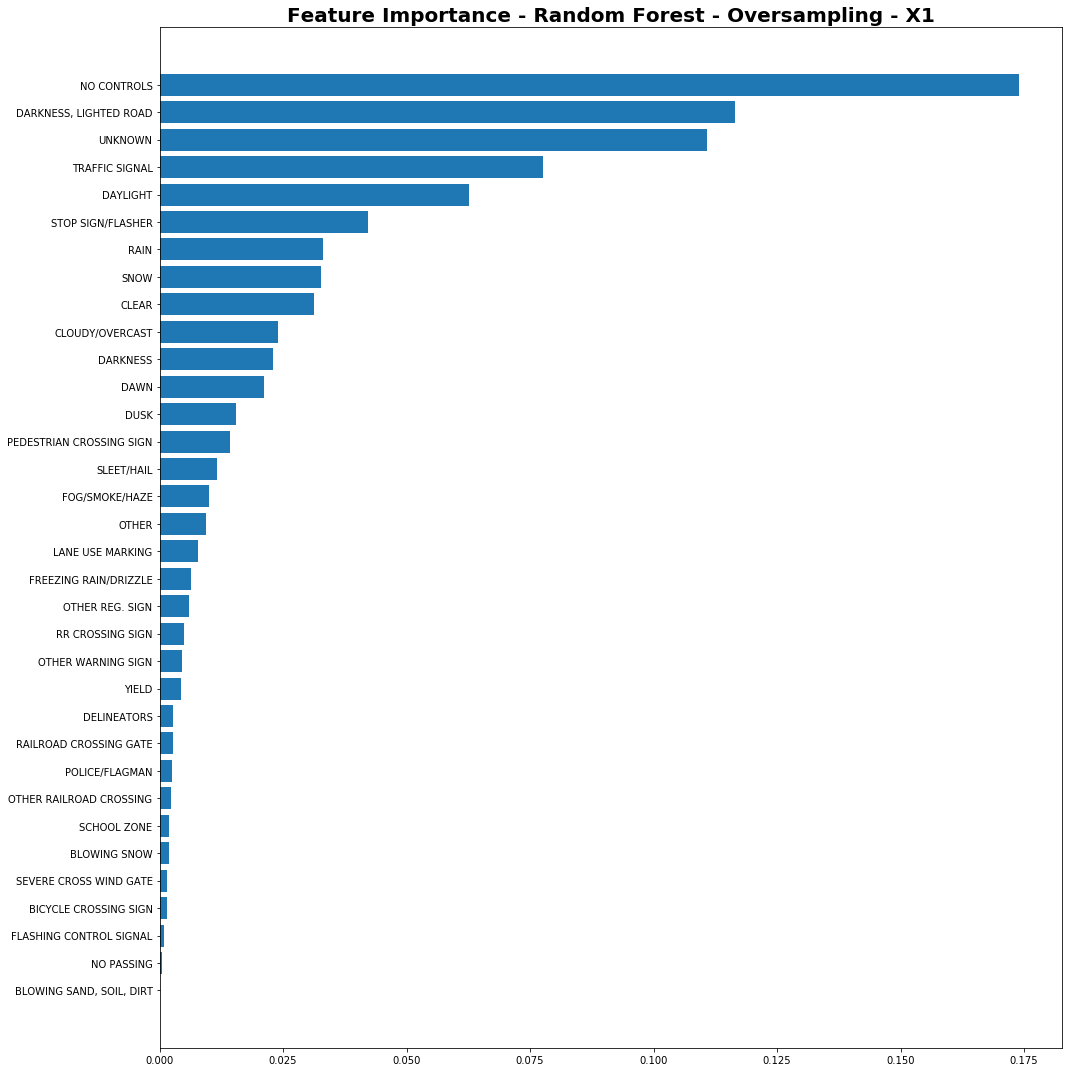

In [30]:
feat_imp_rf_os_1 = rf_rndm_os.feature_importances_
dct_imp_rf_os_1 = {}
for feat, val in zip(X_1.columns, feat_imp_rf_os_1):
    dct_imp_rf_os_1[feat] = val
df_imp_rf_os_1 = pd.DataFrame(dct_imp_rf_os_1, index=[0]).unstack().reset_index()
df_imp_rf_os_1.drop('level_1', axis=1, inplace=True)
df_imp_rf_os_1.columns= ['feature', 'feat_importance']

df_imp_rf_os_1 = df_imp_rf_os_1.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_os_1)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_os_1['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Oversampling - X1", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_os_1['feature'])

fig.tight_layout();

---
### Random Forest - Oversampling - X2

In [31]:
# Replacement is off.
rndm_os_2 = RandomOverSampler(random_state=0)
rndm_os_2.fit(X_2_train, y_2_train.ravel())
X_2_train_rndm_os, y_2_train_rndm_os = rndm_os_2.fit_resample(X_2_train, y_2_train.ravel())

rf_rndm_os_2 = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_os_2.fit(X_2_train_rndm_os, y_2_train_rndm_os.ravel())
y_2_pred_rndm_os = rf_rndm_os_2.predict(X_2_test)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_rndm_os))
print(classification_report(y_2_test.ravel(), y_2_pred_rndm_os))

[[40719 16626]
 [  450   621]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     57345
           1       0.04      0.58      0.07      1071

    accuracy                           0.71     58416
   macro avg       0.51      0.64      0.45     58416
weighted avg       0.97      0.71      0.81     58416



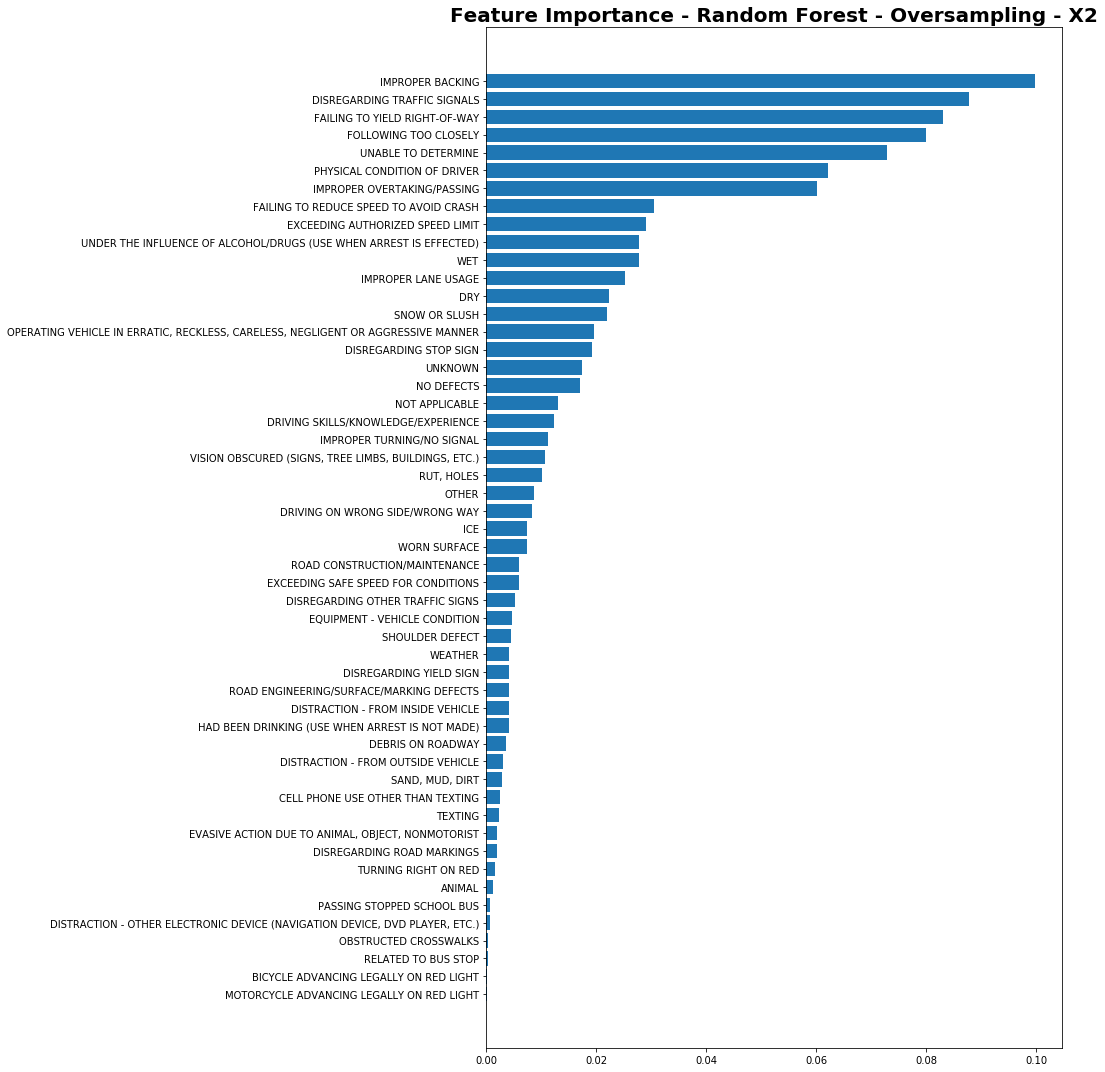

In [32]:
feat_imp_rf_os_2 = rf_rndm_os_2.feature_importances_
dct_imp_rf_os_2 = {}
for feat, val in zip(X_2.columns, feat_imp_rf_os_2):
    dct_imp_rf_os_2[feat] = val
df_imp_rf_os_2 = pd.DataFrame(dct_imp_rf_os_2, index=[0]).unstack().reset_index()
df_imp_rf_os_2.drop('level_1', axis=1, inplace=True)
df_imp_rf_os_2.columns= ['feature', 'feat_importance']
df_imp_rf_os_2 = df_imp_rf_os_2.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_os_2)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_os_2['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Oversampling - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_os_2['feature'])

fig.tight_layout();

---
### Logistic Regression - Oversampling - X1

In [35]:
std_scaler = StandardScaler()
X_1_train_rndm_os_scld = std_scaler.fit_transform(X_1_train_rndm_os)
X_1_test_scld = std_scaler.transform(X_1_test)

log_reg_1 = LogisticRegression(solver='lbfgs').fit(X_1_train_rndm_os_scld, y_1_train_rndm_os.ravel())
y_1_pred_log = log_reg_1.predict(X_1_test_scld)

print(confusion_matrix(y_1_test.ravel(), y_1_pred_log))
print(classification_report(y_1_test.ravel(), y_1_pred_log))

[[28810 28535]
 [  361   710]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.67     57345
           1       0.02      0.66      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.65     58416



---
### Logistic Regression - Oversampling - X2

In [37]:
std_scaler = StandardScaler()
X_2_train_rndm_os_scld = std_scaler.fit_transform(X_2_train_rndm_os)
X_2_test_scld = std_scaler.transform(X_2_test)

log_reg_2 = LogisticRegression(solver='lbfgs').fit(X_2_train_rndm_os_scld, y_2_train_rndm_os.ravel())
y_2_pred_log = log_reg_2.predict(X_2_test_scld)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_log))
print(classification_report(y_2_test.ravel(), y_2_pred_log))

[[42329 15016]
 [  462   609]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     57345
           1       0.04      0.57      0.07      1071

    accuracy                           0.74     58416
   macro avg       0.51      0.65      0.46     58416
weighted avg       0.97      0.74      0.83     58416



---
# Undersampling

---
### Random Forest - Undersampling - X1


In [20]:
rndm_us = RandomUnderSampler(random_state=0)
rndm_us.fit(X_1_train, y_1_train.ravel())
X_train_rndm_us, y_train_rndm_us = rndm_us.fit_resample(X_1_train, y_1_train.ravel())

rf_rndm_us = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_us.fit(X_train_rndm_us, y_train_rndm_us.ravel())
y_pred_rndm_us = rf_rndm_us.predict(X_1_test)

print(confusion_matrix(y_1_test.ravel(), y_pred_rndm_us))
print(classification_report(y_1_test.ravel(), y_pred_rndm_us))

[[40241 39186]
 [  476   852]]
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     79427
           1       0.02      0.64      0.04      1328

    accuracy                           0.51     80755
   macro avg       0.50      0.57      0.36     80755
weighted avg       0.97      0.51      0.66     80755



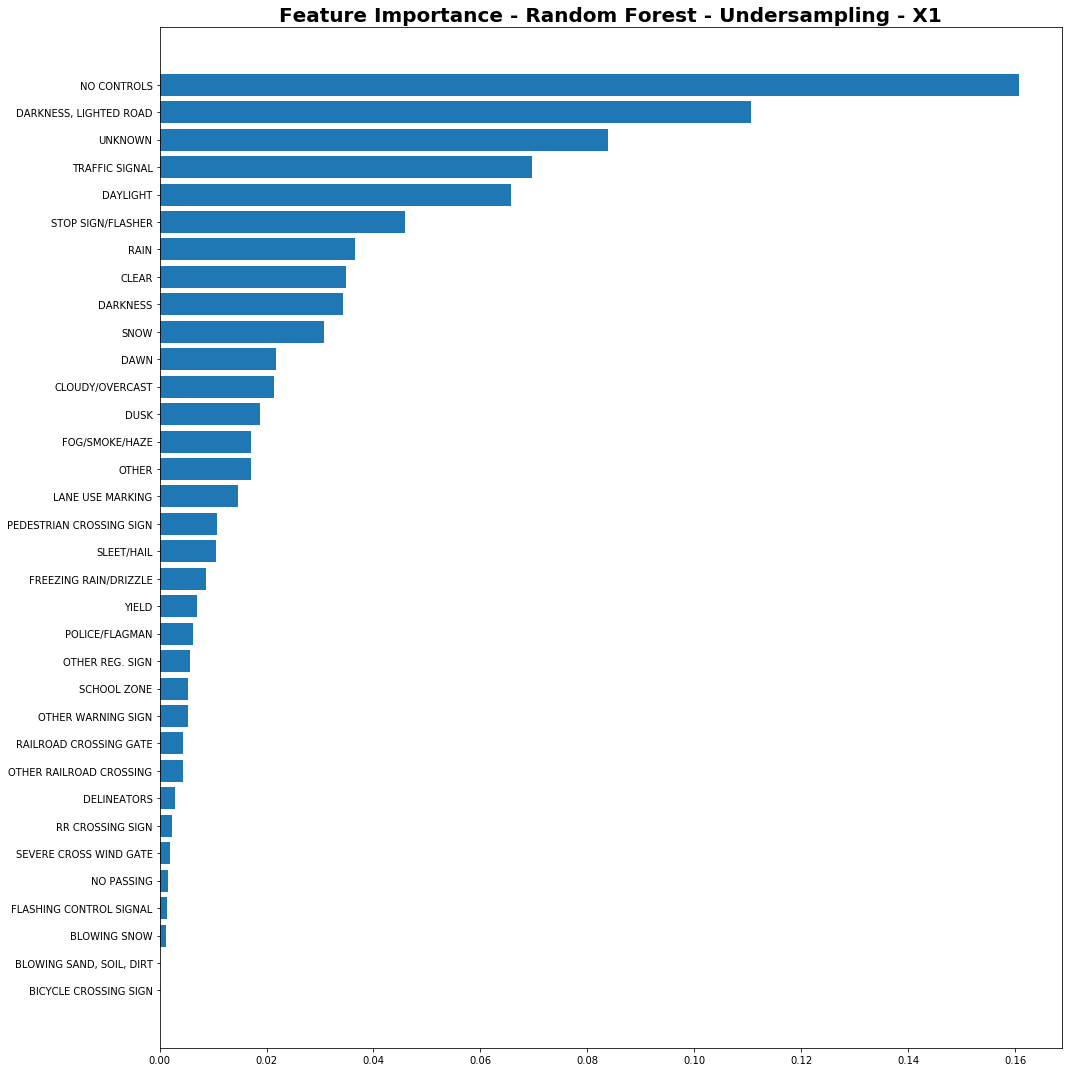

In [21]:
feat_imp_rf_us_1 = rf_rndm_us.feature_importances_
dct_imp_rf_us_1 = {}
for feat, val in zip(X_1.columns, feat_imp_rf_us_1):
    dct_imp_rf_us_1[feat] = val
df_imp_rf_us_1 = pd.DataFrame(dct_imp_rf_us_1, index=[0]).unstack().reset_index()
df_imp_rf_us_1.drop('level_1', axis=1, inplace=True)
df_imp_rf_us_1.columns= ['feature', 'feat_importance']

df_imp_rf_us_1 = df_imp_rf_us_1.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_us_1)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_us_1['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Undersampling - X1", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_us_1['feature'])

fig.tight_layout();

---
### Random Forest - Undersampling - X2

In [22]:
rndm_us_2 = RandomUnderSampler(random_state=0)
rndm_us_2.fit(X_2_train, y_2_train.ravel())
X_2_train_rndm_us, y_2_train_rndm_us = rndm_us_2.fit_resample(X_2_train, y_2_train.ravel())

rf_rndm_us_2 = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_us_2.fit(X_2_train_rndm_us, y_2_train_rndm_us.ravel())
y_2_pred_rndm_us = rf_rndm_us_2.predict(X_2_test)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_rndm_us))
print(classification_report(y_2_test.ravel(), y_2_pred_rndm_us))

[[56462 22965]
 [  549   779]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     79427
           1       0.03      0.59      0.06      1328

    accuracy                           0.71     80755
   macro avg       0.51      0.65      0.44     80755
weighted avg       0.97      0.71      0.82     80755



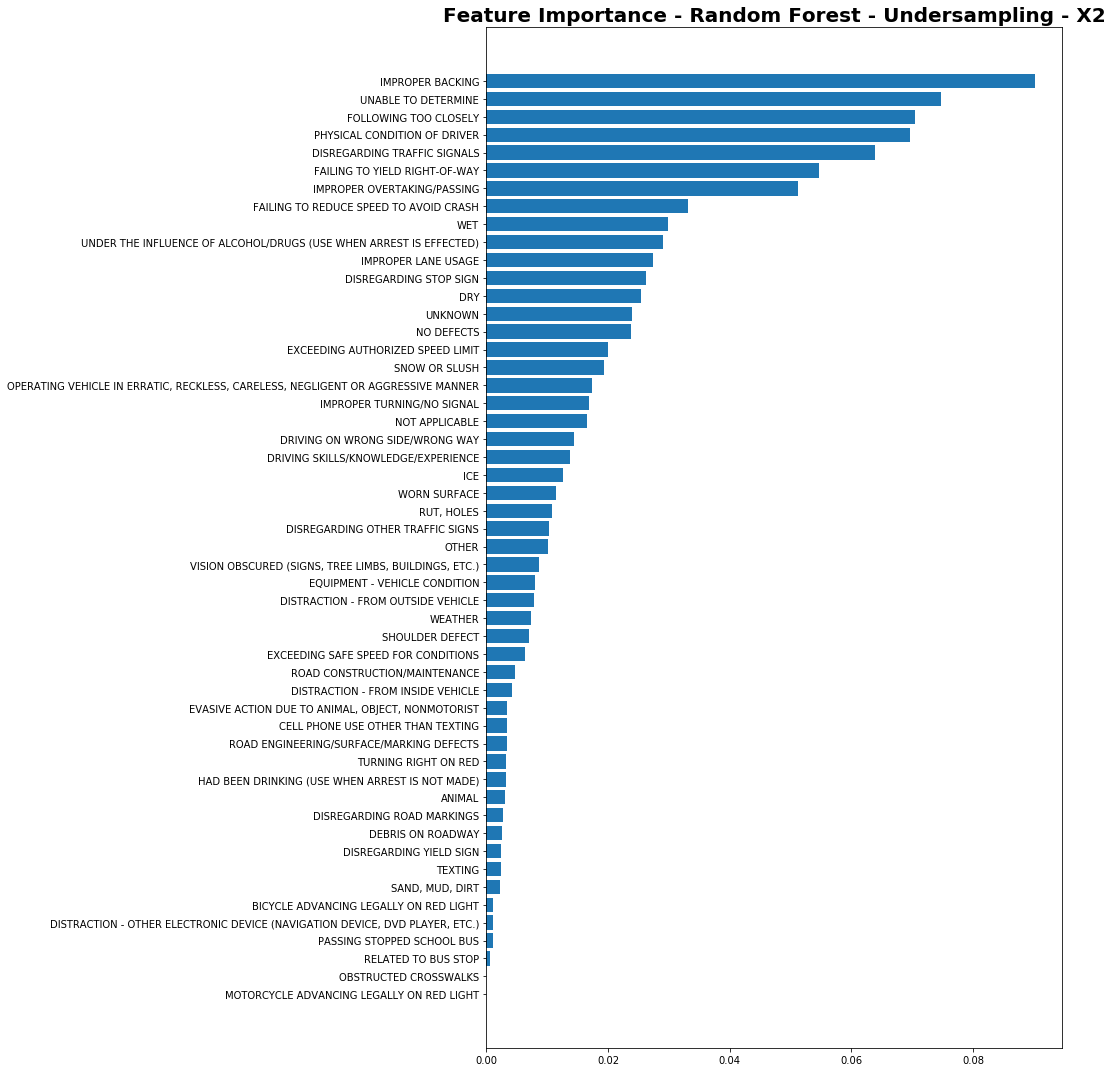

In [23]:
feat_imp_rf_us_2 = rf_rndm_us_2.feature_importances_
dct_imp_rf_us_2 = {}
for feat, val in zip(X_2.columns, feat_imp_rf_us_2):
    dct_imp_rf_us_2[feat] = val
df_imp_rf_us_2 = pd.DataFrame(dct_imp_rf_us_2, index=[0]).unstack().reset_index()
df_imp_rf_us_2.drop('level_1', axis=1, inplace=True)
df_imp_rf_us_2.columns= ['feature', 'feat_importance']

df_imp_rf_us_2 = df_imp_rf_us_2.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_us_2)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_us_2['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Undersampling - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_us_2['feature'])

fig.tight_layout();

---
### Logistic Regression - Undersampling - X1

In [42]:
std_scaler = StandardScaler()
X_1_train_rndm_us_scld = std_scaler.fit_transform(X_train_rndm_us)
X_1_test_scld = std_scaler.transform(X_1_test)

log_reg_1 = LogisticRegression(solver='lbfgs').fit(X_1_train_rndm_us_scld, y_train_rndm_us.ravel())
y_1_pred_log = log_reg_1.predict(X_1_test_scld)

print(confusion_matrix(y_1_test.ravel(), y_1_pred_log))
print(classification_report(y_1_test.ravel(), y_1_pred_log))

[[28740 28605]
 [  366   705]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     57345
           1       0.02      0.66      0.05      1071

    accuracy                           0.50     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.50      0.65     58416



---
### Logistic Regression - Undersampling - X2

In [43]:
std_scaler = StandardScaler()
X_2_train_rndm_us_scld = std_scaler.fit_transform(X_2_train_rndm_us)
X_2_test_scld = std_scaler.transform(X_2_test)

log_reg_2 = LogisticRegression(solver='lbfgs').fit(X_2_train_rndm_us_scld, y_2_train_rndm_us.ravel())
y_2_pred_log = log_reg_2.predict(X_2_test_scld)

print(confusion_matrix(y_2_test.ravel(), y_2_pred_log))
print(classification_report(y_2_test.ravel(), y_2_pred_log))

[[42057 15288]
 [  461   610]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     57345
           1       0.04      0.57      0.07      1071

    accuracy                           0.73     58416
   macro avg       0.51      0.65      0.46     58416
weighted avg       0.97      0.73      0.83     58416



---
### Logistic Regression - Undersampling - X3

In [46]:
rndm_us_3 = RandomUnderSampler(random_state=0)
rndm_us_3.fit(X_3_train, y_3_train.ravel())
X_3_train_rndm_us, y_3_train_rndm_us = rndm_us_3.fit_resample(X_3_train, y_3_train.ravel())

In [47]:
std_scaler = StandardScaler()
X_3_train_rndm_us_scld = std_scaler.fit_transform(X_3_train_rndm_us)
X_3_test_scld = std_scaler.transform(X_3_test)

log_reg_3 = LogisticRegression(solver='lbfgs').fit(X_3_train_rndm_us_scld, y_3_train_rndm_us.ravel())
y_3_pred_log = log_reg_3.predict(X_3_test_scld)

print(confusion_matrix(y_3_test.ravel(), y_3_pred_log))
print(classification_report(y_3_test.ravel(), y_3_pred_log))

[[33459 23886]
 [  387   684]]
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     57345
           1       0.03      0.64      0.05      1071

    accuracy                           0.58     58416
   macro avg       0.51      0.61      0.39     58416
weighted avg       0.97      0.58      0.72     58416



---
## Gradient Boosting - Undersampling - X4

In [45]:
rndm_us_4 = RandomUnderSampler(random_state=0)
rndm_us_4.fit(X_4_train, y_4_train)
X_4_train_us, y_4_train_us = rndm_us_4.fit_resample(X_4_train, y_4_train.ravel())

In [46]:
gdbt_us_4 = GradientBoostingClassifier(learning_rate=0.1, random_state=1, n_estimators=100)
gdbt_us_4.fit(X_4_train_us, y_4_train_us.ravel())
y_4_pred_gdbt_us = gdbt_us_4.predict(X_4_test)

print(confusion_matrix(y_4_test.ravel(), y_4_pred_gdbt_us))
print(classification_report(y_4_test.ravel(), y_4_pred_gdbt_us))

[[61121 18306]
 [  448   880]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     79427
           1       0.05      0.66      0.09      1328

    accuracy                           0.77     80755
   macro avg       0.52      0.72      0.48     80755
weighted avg       0.98      0.77      0.85     80755



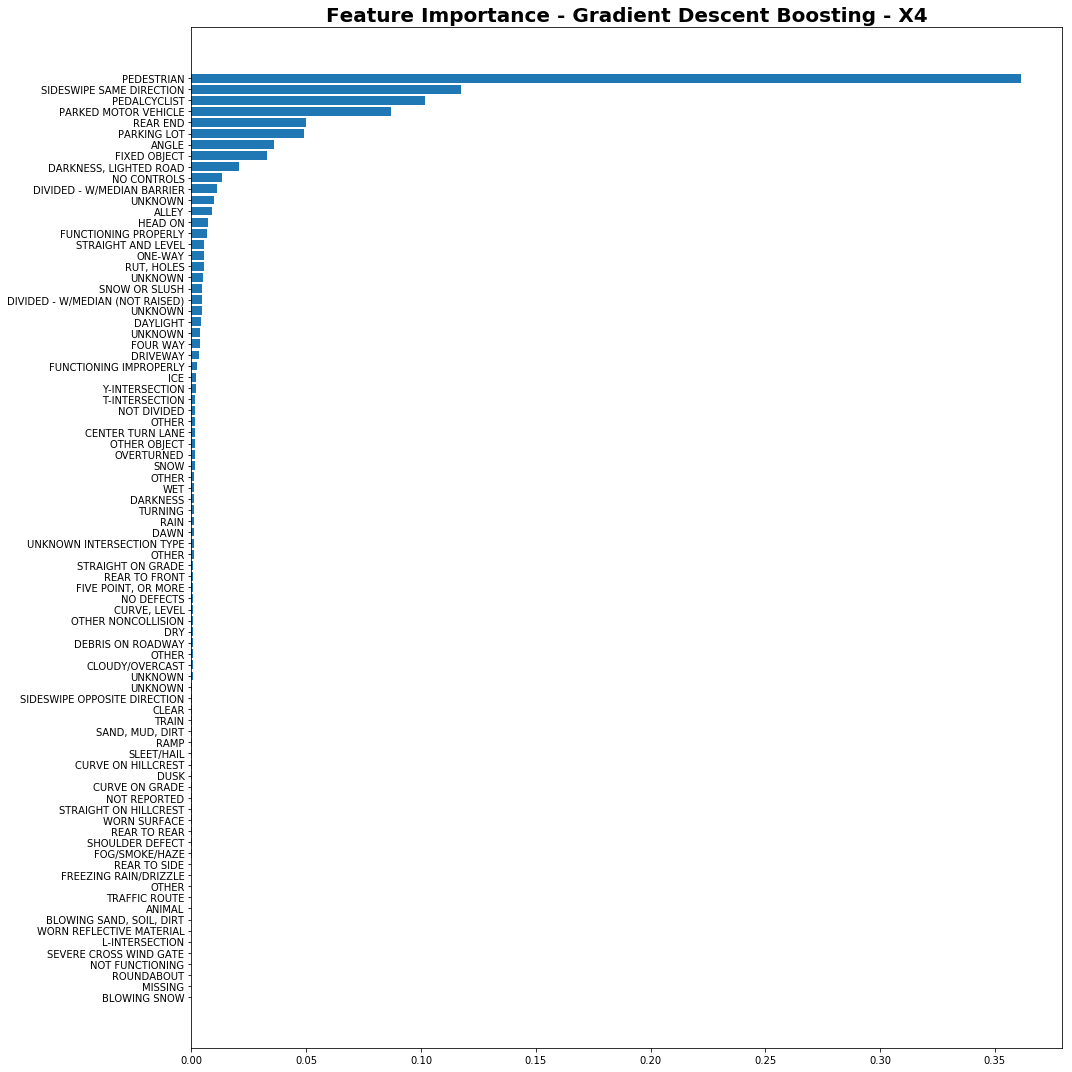

In [47]:
gdbt_us_4_feat_scores = pd.DataFrame({'F-Score': gdbt_us_4.feature_importances_}, index=X_4.columns)
gdbt_us_4_feat_scores = gdbt_us_4_feat_scores.sort_values(by='F-Score')

fig, ax = plt.subplots(figsize=(15,15))
pos_gdbt_4 = np.arange(1, len(gdbt_us_4_feat_scores)+1)

ax.barh(y=pos_gdbt_4, width=gdbt_us_4_feat_scores['F-Score'])
ax.set_title("Feature Importance - Gradient Descent Boosting - X4", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos_gdbt_4)
ax.set_yticklabels(labels=gdbt_us_4_feat_scores.index)

fig.tight_layout();

---
## GridSearch

In [48]:
# Set GridSearch parameters

gs_params_1 = {
    "loss" : ["deviance"], # means log loss. appropriate for classification
    "learning_rate" : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators" : [10, 25, 50, 100],
    "criterion" : ['friedman_mse', 'mse', 'mae'],
    "max_depth" : [3, 5, 7], 
    "random_state": [1]
}

gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1), param_grid=gs_params_1, cv=5, n_jobs=-1, 
                       scoring = 'recall')

gsearch1.fit(X_3_train_rndm_us, y_3_train_rndm_us.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mse', 'mae'],
                         'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                           0.2],
                         'loss': ['deviance'], 'max_depth': [3, 5, 7],
                         'n_estimators': [10, 25, 50, 100],
                         'random_state': [1]},
             scoring='recall')

In [49]:
print("Grid Search 1 - Gradient Boosting Classifier - Undersampled") 
#print("\n All results:")
#print(gsearch1.cv_results_)
print("\n Best estimator: ")
print(gsearch1.best_estimator_)
print("\n Best score: ")
print(gsearch1.best_score_)
print("\n Best parameters:")
print(gsearch1.best_params_)
gs1_results = pd.DataFrame(gsearch1.cv_results_)
gs1_results.to_csv('gdbt-grid-search-01.csv', index=False)

Grid Search 1 - Gradient Boosting Classifier - Undersampled

 Best estimator: 
GradientBoostingClassifier(criterion='mae', learning_rate=0.05, max_depth=5,
                           random_state=1)

 Best score: 
0.6836797197357292

 Best parameters:
{'criterion': 'mae', 'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100, 'random_state': 1}


In [50]:
y_pred_gs1 = gsearch1.best_estimator_.predict(X_3_test)
print(confusion_matrix(y_3_test, y_pred_gs1))
print(classification_report(y_3_test, y_pred_gs1))

[[28672 28673]
 [  305   766]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     57345
           1       0.03      0.72      0.05      1071

    accuracy                           0.50     58416
   macro avg       0.51      0.61      0.36     58416
weighted avg       0.97      0.50      0.65     58416



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


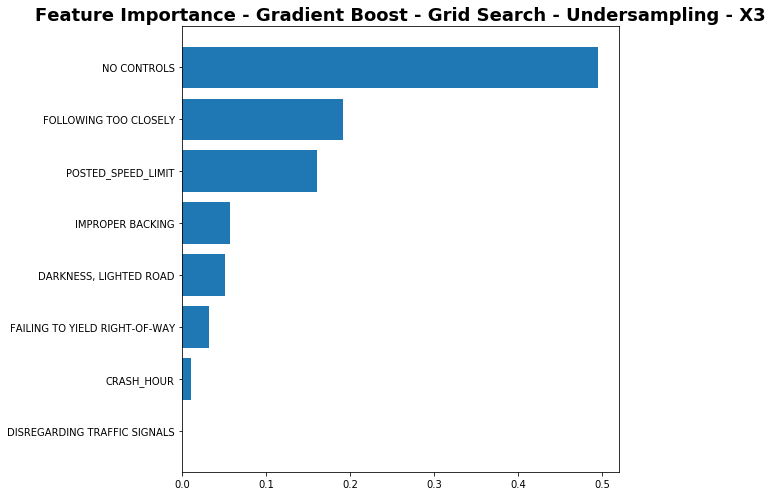

In [51]:
feat_imp_gs_1 = gsearch1.best_estimator_.feature_importances_
dct_imp_gs_1 = {}
for feat, val in zip(X_3.columns, feat_imp_gs_1):
    dct_imp_gs_1[feat] = val
df_imp_gs_1 = pd.DataFrame(dct_imp_gs_1, index=[0]).unstack().reset_index()
df_imp_gs_1.drop('level_1', axis=1, inplace=True)
df_imp_gs_1.columns= ['feature', 'feat_importance']

df_imp_gs_1 = df_imp_gs_1.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(10,7))
y_pos = np.arange(1, len(df_imp_gs_1)+1)

ax.barh(y=y_pos, width=df_imp_gs_1['feat_importance'])
       
ax.set_title("Feature Importance - Gradient Boost - Grid Search - Undersampling - X3", fontsize=18, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_gs_1['feature'])

fig.tight_layout();

---
## GridSearch - Gradient Boosting - Undersampling - X2

In [24]:
# Set GridSearch parameters

gs_params_2 = {
    "loss" : ["deviance"], # means log loss. appropriate for classification
    "learning_rate" : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators" : [10, 25, 50, 100],
    "criterion" : ['friedman_mse', 'mse', 'mae'],
    "max_depth" : [3, 5, 7], 
    "random_state": [1]
}

gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1), param_grid=gs_params_2, cv=5, n_jobs=-1, 
                       scoring = 'recall')

gsearch2.fit(X_2_train_rndm_us, y_2_train_rndm_us.ravel())

KeyboardInterrupt: 

In [ ]:
print("Grid Search 2 - Gradient Boosting Classifier - Undersampled") 
#print("\n All results:")
#print(gsearch2.cv_results_)
print("\n Best estimator: ")
print(gsearch2.best_estimator_)
print("\n Best score: ")
print(gsearch2.best_score_)
print("\n Best parameters:")
print(gsearch2.best_params_)
gs2_results = pd.DataFrame(gsearch2.cv_results_)
#gs1_results.to_csv('gdbt-grid-search-01.csv', index=False)

---
## ROC Curves - Summary